In [1]:
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

In [2]:
class PCNET(nn.Module):
    def __init__(self, model: nn.Module, rescaling: float = 1.0):
        super().__init__()
        self.activation = F.tanh
        self.rc = rescaling
        self.energy = torch.zeros(1)
        self.criterion = nn.MSELoss(reduction='sum')

        self.module_dict = {'generative': nn.ModuleList()}
        for name, module in model.named_children():
            if isinstance(module, nn.ModuleList):
                for i, submodule in enumerate(module):
                    copied = copy.deepcopy(submodule)
                    self.module_dict['generative'].append(copied)
                    self.add_module(f"{name}_{i}", copied)
            else:
                copied = copy.deepcopy(module)
                self.module_dict['generative'].append(copied)
                self.add_module(name, copied)


    def to(self, device: torch.device):
        super().to(device)
        self.energy = self.energy.to(device)
        return self

    def update_energy(self, input_data, output):
        generative = self.module_dict['generative']
        variational = self.module_dict['variational']

        pred = generative[-1](self.activation(variational[-1]))

        energy = self.criterion(variational[0], generative[0](self.activation(input_data)))
        for k in range(1, len(generative) - 1):
            energy += self.criterion(variational[k], generative[k](self.activation(variational[k - 1])))
        energy += self.criterion(output, pred) / self.rc

        return energy, pred

    def inference_phase(self, input: torch.Tensor, output: torch.Tensor, alpha: float = 0.01, inference_timestamps: int = 10):
        generative = self.module_dict['generative']
        self.module_dict['variational'] = nn.ParameterList([
            nn.Parameter(generative[0](self.activation(input)).detach().clone())
        ])

        for j in range(1, len(generative) - 1):
            self.module_dict['variational'].append(
                nn.Parameter(generative[j](self.activation(self.module_dict['variational'][j - 1])).detach().clone())
            )

        optimizer = torch.optim.SGD(self.module_dict['variational'], lr=alpha)

        for _ in range(inference_timestamps):
            self.energy, _ = self.update_energy(input, output)
            self.energy.backward()
            optimizer.step()
            optimizer.zero_grad()

        return self.module_dict['generative'][-1](self.activation(self.module_dict['variational'][-1]))

    def forward(self, x: torch.Tensor):
        for layer in self.module_dict['generative']:
            x = self.activation(layer(x))
        return x


In [3]:
class MLP(nn.Module):
    def __init__(self, input_size: int, hidden_layers: int, hidden_size: int, output_size: int):
        super(MLP, self).__init__()
        
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_size, hidden_size) for _ in range(hidden_layers - 1)]
        )
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x: torch.Tensor):
        x = self.input_layer(F.tanh(x))
        for layer in self.hidden_layers:
            x = layer(F.tanh(x))
        x = self.output_layer(F.tanh(x))
        return x

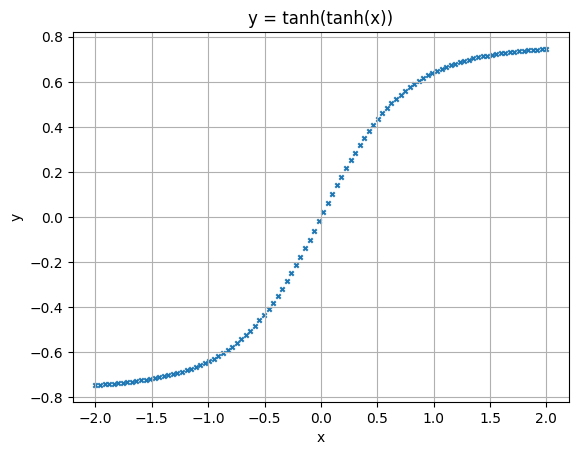

In [4]:
dataset_size = 100

x = np.linspace(-2, 2, dataset_size)
y = torch.tanh(torch.tanh(torch.tensor(x))).numpy()

plt.scatter(x, y, s=10, marker='x')
plt.xlabel('x')
plt.ylabel('y')
plt.title('y = tanh(tanh(x))')
plt.grid(True)
plt.show()

x = torch.tensor(x).float().reshape(dataset_size, 1, 1)
y = torch.tensor(y).float().reshape(dataset_size, 1, 1)

In [5]:
resolution = 100
theta_vals = np.linspace(-3, 3, resolution)
grid = [(i, j) for i in theta_vals for j in theta_vals]

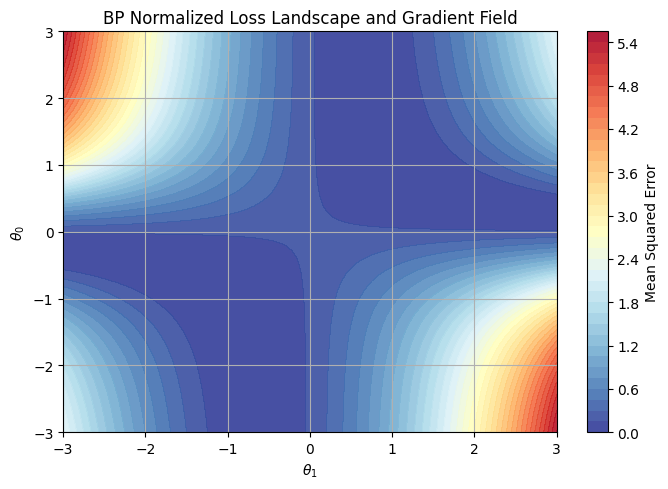

In [6]:
def run_bp(i, j):
    model = MLP(1, 0, 1, 1)

    with torch.no_grad():
        model.input_layer.weight.fill_(j)
        model.input_layer.bias.fill_(0.0)
        model.output_layer.weight.fill_(i)
        model.output_layer.bias.fill_(0.0)

    outputs = model(x)
    criterion = nn.MSELoss(reduction='sum')
    loss = 0.5 * criterion(outputs.flatten(), y.flatten()) / dataset_size
    loss.backward()

    return {
        'theta1': i,
        'theta0': j,
        'se': loss.detach().item(),
        'grad1': model.output_layer.weight.grad.item(),
        'grad0': model.input_layer.weight.grad.item(),
    }

bp_results = Parallel(n_jobs=10)(delayed(run_bp)(i, j) for i, j in grid)
bp_df = pd.DataFrame(bp_results)

bp_theta1, bp_theta0, loss = (
    bp_df[col].values.reshape(resolution, resolution)
    for col in ['theta1', 'theta0', 'se']
)

plt.figure(figsize=(7, 5))
sc = plt.contourf(bp_theta1, bp_theta0, loss, levels=50, cmap='RdYlBu_r', alpha=0.9)

plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_0$')
plt.title('BP Normalized Loss Landscape and Gradient Field')
plt.colorbar(sc, label='Mean Squared Error')
plt.grid(True)
plt.tight_layout()
plt.show()


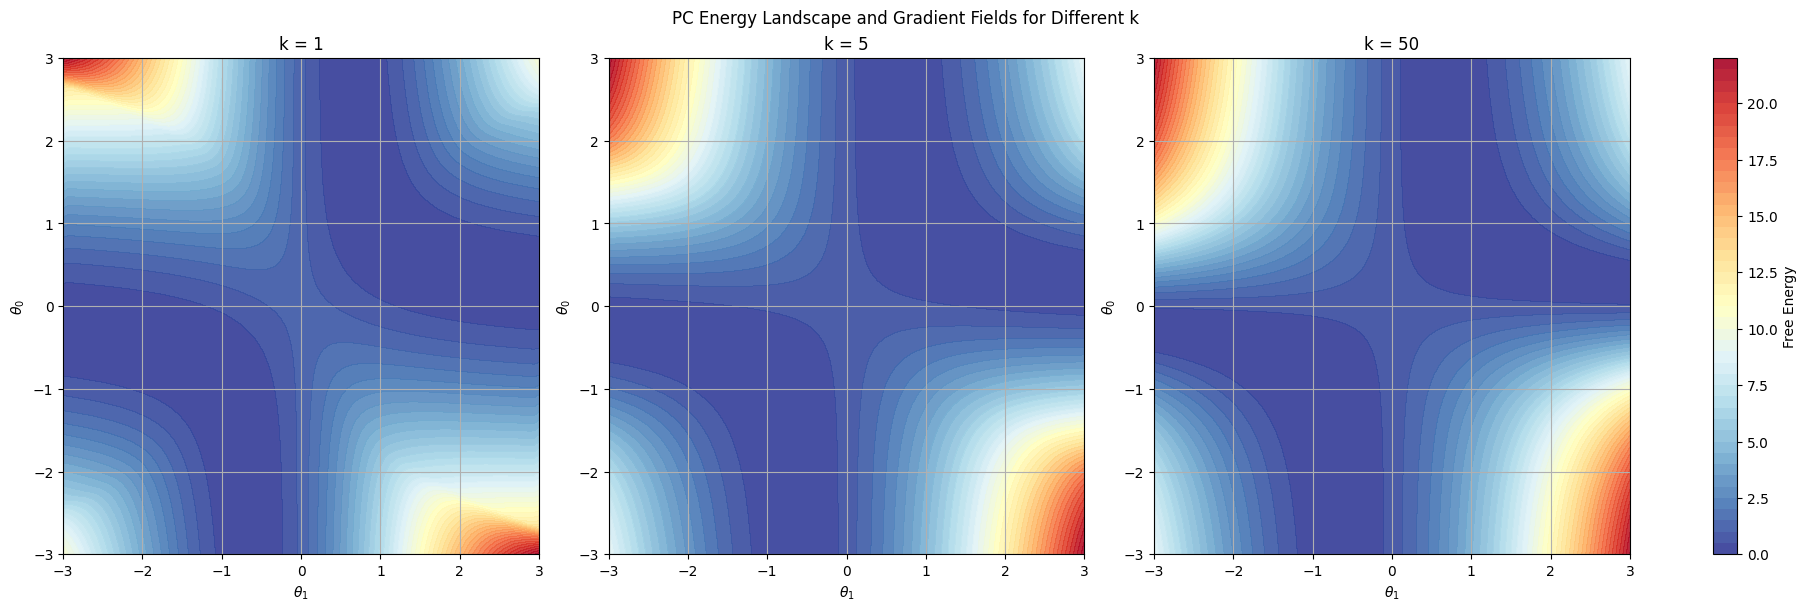

In [7]:
def run_pc(i, j, k_val):
    base_model = MLP(1, 0, 1, 1)
    pc_net = PCNET(base_model, rescaling=k_val)

    with torch.no_grad():
        pc_net.module_dict['generative'][0].weight.fill_(j)
        pc_net.module_dict['generative'][0].bias.fill_(0.0)
        pc_net.module_dict['generative'][1].weight.fill_(i)
        pc_net.module_dict['generative'][1].bias.fill_(0.0)

    _ = pc_net.inference_phase(x, y, alpha=0.1, inference_timestamps=30)

    return {
        'theta1': i,
        'theta0': j,
        'se': pc_net.energy.item(),
        'grad1': pc_net.module_dict['generative'][1].weight.grad.item(),
        'grad0': pc_net.module_dict['generative'][0].weight.grad.item(),
    }

k_values = [1, 5, 50]
dfs = []

for kv in k_values:
    results = Parallel(n_jobs=10)(delayed(run_pc)(i, j, kv) for i, j in grid)
    dfs.append(pd.DataFrame(results))

spacing = 8
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

for ax, df, k in zip(axes, dfs, k_values):
    theta1, theta0, energy = (
        df[col].values.reshape(resolution, resolution)
        for col in ['theta1', 'theta0', 'se']
    )

    sc = ax.contourf(theta1, theta0, energy, levels=50, cmap='RdYlBu_r', alpha=0.9)
    ax.set_title(f'k = {k}')
    ax.set_xlabel(r'$\theta_1$')
    ax.set_ylabel(r'$\theta_0$')
    ax.grid(True)

fig.suptitle('PC Energy Landscape and Gradient Fields for Different k')
fig.colorbar(sc, ax=axes.ravel().tolist(), label='Free Energy')
plt.show()


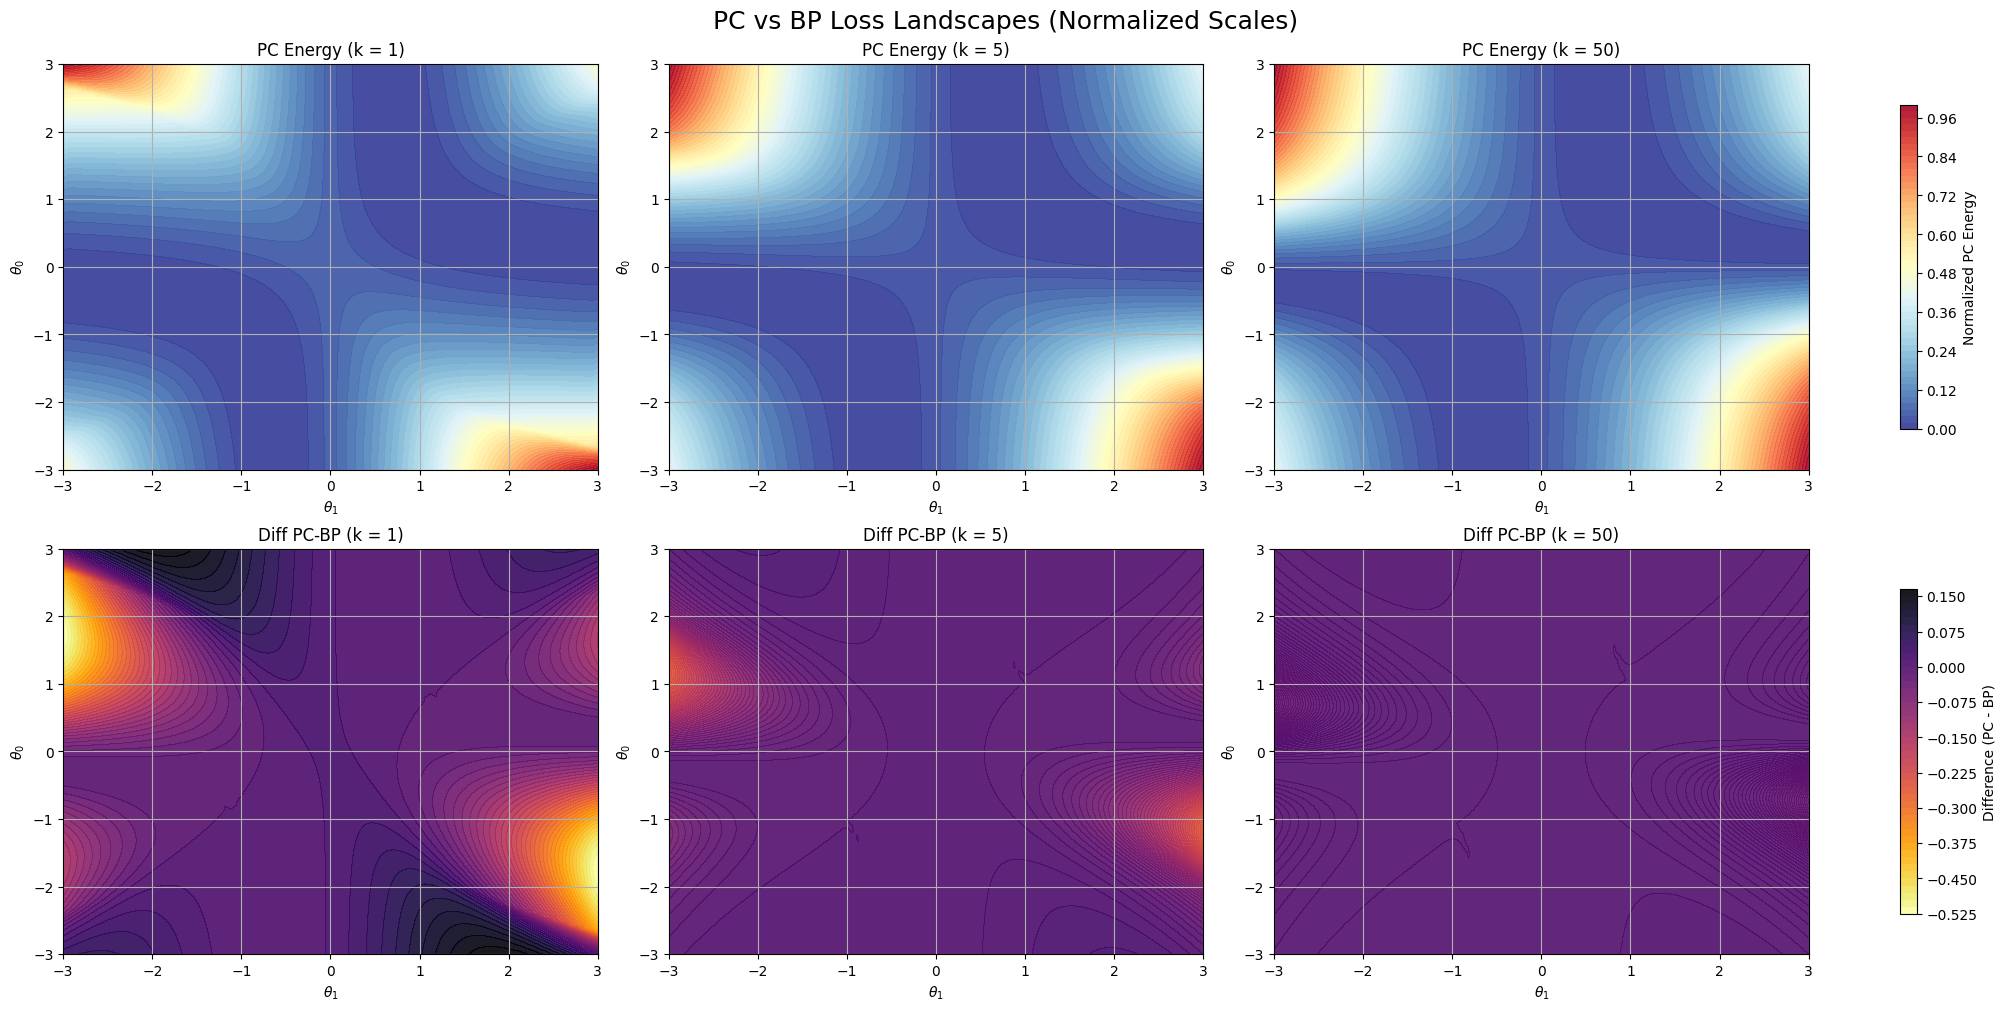

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10), constrained_layout=True)

bp_theta1 = bp_df['theta1'].values.reshape(resolution, resolution)
bp_theta0 = bp_df['theta0'].values.reshape(resolution, resolution)
loss = bp_df['se'].values.reshape(resolution, resolution)
loss_norm = loss / np.max(loss)

diffs = []
energies = []

for df in dfs:
    energy = df['se'].values.reshape(resolution, resolution)
    energy_norm = energy / np.max(energy)
    diff = energy_norm - loss_norm
    energies.append(energy_norm)
    diffs.append(diff)

vmin_diff = np.min([d.min() for d in diffs])
vmax_diff = np.max([d.max() for d in diffs])

vmin_energy = 0
vmax_energy = 1


sc1_ref, sc2_ref = None, None

for idx, (energy_norm, diff, k) in enumerate(zip(energies, diffs, k_values)):
    sc1 = axes[0, idx].contourf(bp_theta1, bp_theta0, energy_norm, levels=50, cmap='RdYlBu_r',
                                vmin=vmin_energy, vmax=vmax_energy, alpha=0.9)
    axes[0, idx].set_title(f'PC Energy (k = {k})')
    axes[0, idx].set_xlabel(r'$\theta_1$')
    axes[0, idx].set_ylabel(r'$\theta_0$')
    axes[0, idx].grid(True)

    if sc1_ref is None:
        sc1_ref = sc1

    sc2 = axes[1, idx].contourf(bp_theta1, bp_theta0, diff, levels=50, cmap='inferno_r',
                                vmin=vmin_diff, vmax=vmax_diff, alpha=0.9)
    axes[1, idx].set_title(f'Diff PC-BP (k = {k})')
    axes[1, idx].set_xlabel(r'$\theta_1$')
    axes[1, idx].set_ylabel(r'$\theta_0$')
    axes[1, idx].grid(True)

    if sc2_ref is None:
        sc2_ref = sc2

fig.colorbar(sc1_ref, ax=axes[0, :], shrink=0.8, label='Normalized PC Energy')
fig.colorbar(sc2_ref, ax=axes[1, :], shrink=0.8, label='Difference (PC - BP)')

fig.suptitle('PC vs BP Loss Landscapes (Normalized Scales)', fontsize=18)
plt.show()


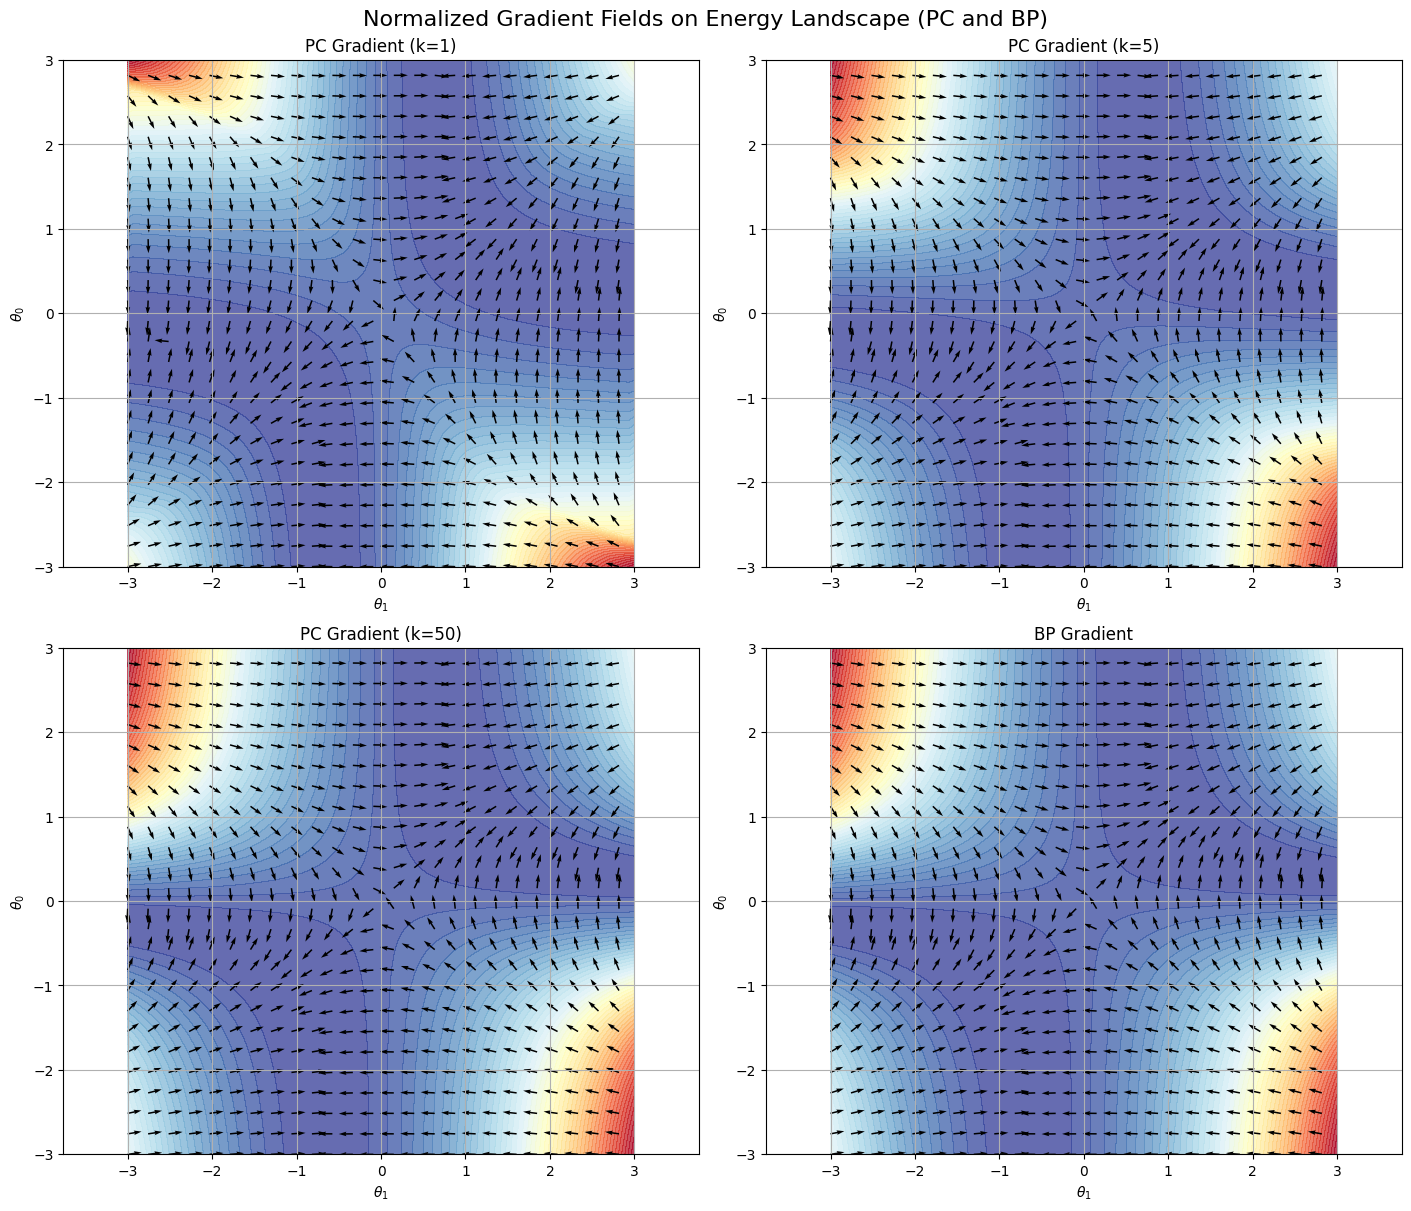

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12), constrained_layout=True)

spacing = 4
vmin_energy = 0
vmax_energy = 1

# Plot PC gradients
for idx, (df, k) in enumerate(zip(dfs, k_values)):
    theta1 = df['theta1'].values.reshape(resolution, resolution)
    theta0 = df['theta0'].values.reshape(resolution, resolution)
    grad1 = df['grad1'].values.reshape(resolution, resolution)
    grad0 = df['grad0'].values.reshape(resolution, resolution)
    energy = df['se'].values.reshape(resolution, resolution)
    norm_en = energy / np.max(energy)

    t1_sub = theta1[::spacing, ::spacing]
    t0_sub = theta0[::spacing, ::spacing]
    g1_sub = grad1[::spacing, ::spacing]
    g0_sub = grad0[::spacing, ::spacing]

    norm = np.sqrt(g1_sub**2 + g0_sub**2) + 1e-8
    g1_norm = g1_sub / norm
    g0_norm = g0_sub / norm

    ax = axes[idx // 2, idx % 2]
    ax.contourf(theta1, theta0, norm_en, levels=50, cmap='RdYlBu_r',
                vmin=vmin_energy, vmax=vmax_energy, alpha=0.75)
    ax.quiver(t1_sub, t0_sub, -g1_norm, -g0_norm, angles='xy', scale_units='xy', scale=6, color='black')
    ax.set_title(f'PC Gradient Field (k={k})')
    ax.set_xlabel(r'$\theta_1$')
    ax.set_ylabel(r'$\theta_0$')
    ax.grid(True)
    ax.axis('equal')

# Plot BP gradients in the last subplot
theta1_bp = bp_df['theta1'].values.reshape(resolution, resolution)
theta0_bp = bp_df['theta0'].values.reshape(resolution, resolution)
grad1_bp = bp_df['grad1'].values.reshape(resolution, resolution)
grad0_bp = bp_df['grad0'].values.reshape(resolution, resolution)
energy_bp = bp_df['se'].values.reshape(resolution, resolution)
norm_en_bp = energy_bp / np.max(energy_bp)

t1_sub = theta1_bp[::spacing, ::spacing]
t0_sub = theta0_bp[::spacing, ::spacing]
g1_sub = grad1_bp[::spacing, ::spacing]
g0_sub = grad0_bp[::spacing, ::spacing]

norm = np.sqrt(g1_sub**2 + g0_sub**2) + 1e-8
g1_norm = g1_sub / norm
g0_norm = g0_sub / norm

ax = axes[1, 1]
ax.contourf(theta1_bp, theta0_bp, norm_en_bp, levels=50, cmap='RdYlBu_r',
            vmin=vmin_energy, vmax=vmax_energy, alpha=0.75)
ax.quiver(t1_sub, t0_sub, -g1_norm, -g0_norm, angles='xy', scale_units='xy', scale=6, color='black')
ax.set_title('BP Gradient')
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_0$')
ax.grid(True)
ax.axis('equal')

plt.suptitle('Normalized Gradient Fields on Energy Landscape (PC and BP)', fontsize=16)
plt.show()
